In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN as DBSCAN_SKLEARN
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_moons
from time import perf_counter


In [2]:
class DBSCAN:
    point_types= {
        'undefined': 0,
        'core': 1,
        'border': 2,
        'noise': 3,
        'fake_noise': 4
    }

    def __init__(self, minPoints, eps):
        self.minPoints = minPoints
        self.eps = eps
        
        self.undefined_points = None
        self.points = None

    def init_point_type(self, index, in_cluster=False):
        neighborhood = np.argwhere(self.distances[index] < self.eps).reshape(-1)
        if neighborhood.shape[0] < self.minPoints:
            if in_cluster:
                self.points[index] = DBSCAN.point_types['border']
            else:
                self.points[index] = DBSCAN.point_types['fake_noise']
        else:
            self.points[index] = DBSCAN.point_types['core']

    def get_free_index(self):
        free_indices = np.argwhere(
            (self.expectation == 0) &
            (self.points == DBSCAN.point_types['core'])
        ).reshape(-1)
        if free_indices.shape[0]:
            return np.random.choice(free_indices)
        else:
            return -1

    def get_neighborhood(self, index):
        indices = np.where(self.distances[index] < self.eps)[0]
        return indices[
            np.where((self.points[indices] == DBSCAN.point_types['core']) |
                     (self.points[indices] == DBSCAN.point_types['fake_noise']))[0]
        ]

    def assign_cluster(self, index, value, point_type):
        self.expectation[index] = value
        self.points[index] = point_type

    def grow_cluster(self, index, current_cluster):
        neighborhood = self.get_neighborhood(index)
        if neighborhood.shape[0] < self.minPoints:
            self.assign_cluster(index, -current_cluster, DBSCAN.point_types['border'])
            
        else:
            self.assign_cluster(index, current_cluster, DBSCAN.point_types['core'])
            for i in neighborhood:
                if i != index and self.expectation[i] == 0:
                    self.grow_cluster(i, current_cluster)

    def fit(self, X: np.ndarray):
        self.distances = pairwise_distances(X, X)
        self.expectation = np.zeros(X.shape[0])

        self.points = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            self.init_point_type(i)

        t = True
        current_cluster = 0

        while t:
            current_cluster += 1

            index = self.get_free_index()
            if index == -1:
                self.points[self.points == DBSCAN.point_types['fake_noise']] = DBSCAN.point_types['noise']
                print('No unassigned core points')
                break

            self.assign_cluster(index, current_cluster, DBSCAN.point_types['core'])

            neighborhood = self.get_neighborhood(index)
            for i in neighborhood:
                self.grow_cluster(i, current_cluster)

    def predict(self, X):
        return np.abs(self.expectation)


0.010893899999999235
No unassigned core points
0.03528140000000235


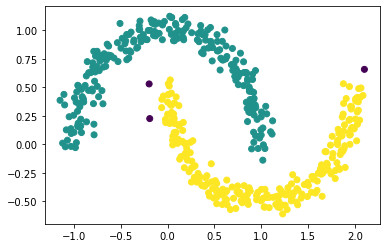

In [3]:
X, y_true = make_moons(n_samples=500, noise=0.07)


db = DBSCAN_SKLEARN(eps=0.15)
t01 = perf_counter()
db.fit(X)
t02 = perf_counter()
print(t02 - t01)

dbscan = DBSCAN(5, 0.15)
t1 = perf_counter()
dbscan.fit(X)
t2 = perf_counter()
print(t2-t1)

y_pred = dbscan.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()
